In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm
from sklearn.feature_selection import mutual_info_regression
import theano
import theano.tensor as tt
from pymc3.distributions.bound import bound
import arviz as az

In [3]:
@theano.compile.ops.as_op(itypes=[tt.dscalar, tt.dscalar],
                          otypes=[tt.dscalar])
def numpy_normal(s1,s2):
        #s1,s2 = X
        x = np.random.normal(0, s1, size=10_000)
        y = np.random.normal(0, s2, size=10_000)

        out = x+y
        I = mutual_info_regression(x.reshape((-1,1)),out, discrete_features=False)[0]
        return np.array(I, dtype=np.float64)

In [86]:
with pm.Model() as model:
    s1 = pm.Uniform("X", 10,1000)
    s2 = pm.Uniform("Y", 10,1000)
    
    Is = numpy_normal(s1,s2)
    obs = pm.Normal("obs", Is > 4, 0.1, observed = 1)
    
    trace = pm.sample(1000, cores=1, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [Y]
>Slice: [X]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5201 seconds.


/home/maoj/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'X'}>,
       <AxesSubplot:title={'center':'Y'}>], dtype=object)

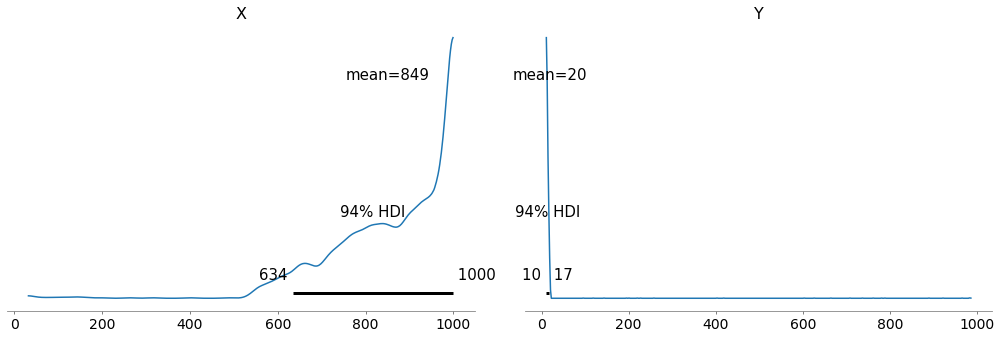

In [88]:
az.plot_posterior(trace)

In [5]:
@theano.compile.ops.as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar],
                          otypes=[tt.dscalar])
def numpy_normal2(s1,s2, mu1, mu2):
        #s1,s2 = X
        x = np.random.normal(mu1, s1, size=10_000)
        y = np.random.normal(mu2, s2, size=10_000)

        out = x+y
        I = mutual_info_regression(x.reshape((-1,1)),out, discrete_features=False)[0]
        return np.array(I, dtype=np.float64)
    
with pm.Model() as model:
    s1 = pm.Uniform("std1", 10,1000)
    mus1 = pm.Uniform("mu1", -1000,1000)
    s2 = pm.Uniform("std2", 10,1000)
    mus2 = pm.Uniform("mu2", -1000,1000)
    
    Is = pm.Deterministic("out", numpy_normal2(s1,s2, mus1, mus2))
    obs = pm.Normal("obs", Is > 4, 0.1, observed = 1)
    
    trace = pm.sample(1000, cores=2, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [mu2]
>Slice: [std2]
>Slice: [mu1]
>Slice: [std1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3850 seconds.
The number of effective samples is smaller than 25% for some parameters.


/home/maoj/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'std1'}>,
        <AxesSubplot:title={'center':'mu1'}>,
        <AxesSubplot:title={'center':'std2'}>],
       [<AxesSubplot:title={'center':'mu2'}>,
        <AxesSubplot:title={'center':'out'}>, <AxesSubplot:>]],
      dtype=object)

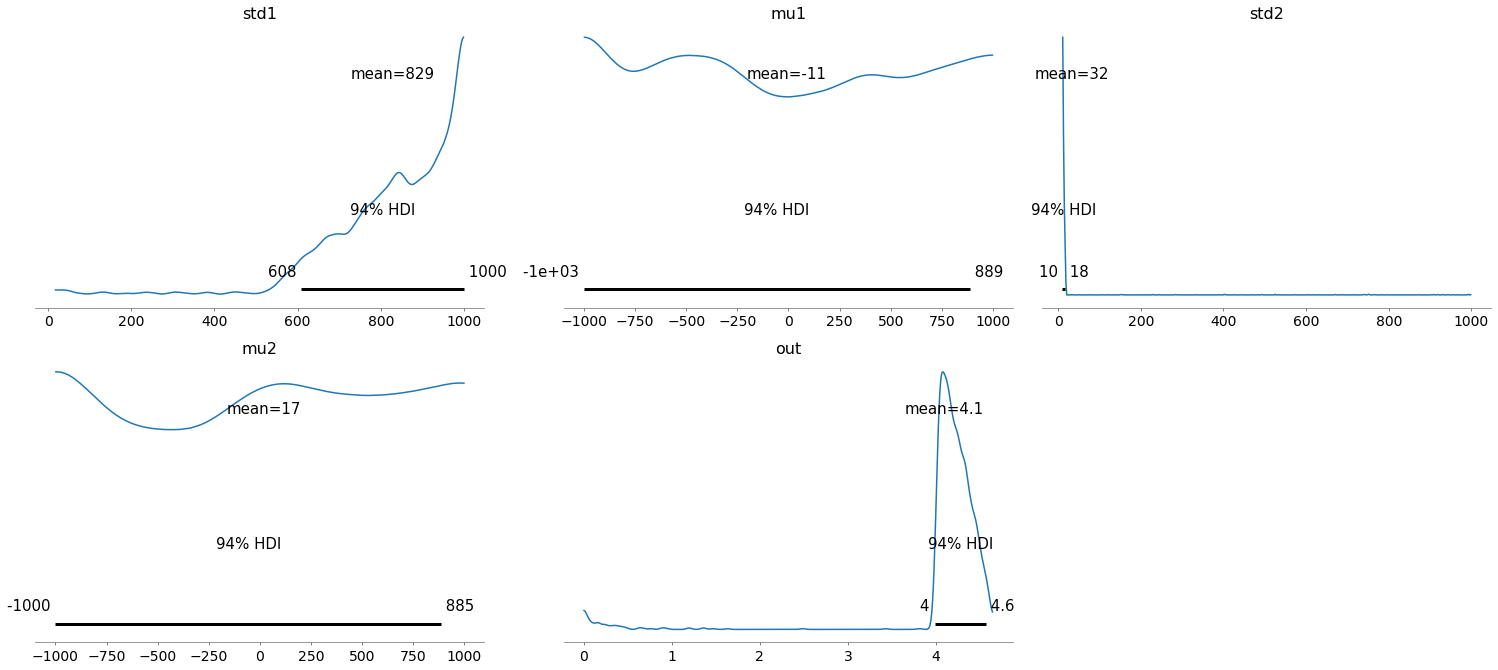

In [8]:
az.plot_posterior(trace)

In [12]:
best = np.argmax(trace["out"])
print(trace["out"][best], trace["std1"][best], trace["std2"][best])

4.644453339727098 991.8532848270826 10.0003848099918


In [34]:
trace["out"][np.asarray(trace["std1"] >= 999) & np.asarray(trace["std2"] <= 11)]

array([4.5534336 , 4.58608763, 4.61797059, 4.54111996, 4.58112849,
       4.57514465, 4.60291314, 4.53907607, 4.55960222])

In [46]:
@theano.compile.ops.as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar],
                          otypes=[tt.dscalar])
def analytical_solution(mu1, mu2, std_alice, std_res):
    return np.array((np.log(std_alice**2+std_res**2)-np.log(std_res**2))/2)

In [56]:
with pm.Model() as model:
    s1 = pm.Uniform("std1", 10,1000)
    mus1 = pm.Uniform("mu1", -1000,1000)
    s2 = pm.Uniform("std2", 10,1000)
    mus2 = pm.Uniform("mu2", -1000,1000)
    
    Is = pm.Deterministic("out", (np.log(np.power(s1,2) + np.power(s2,2)) -np.log(np.power(s2,2)))/2)
    obs = pm.Normal("obs", Is> 4.6, 0.1, observed = 1)
    
    trace = pm.sample(10_000, cores=2, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu2, std2, mu1, std1]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


/home/maoj/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'std1'}>,
        <AxesSubplot:title={'center':'mu1'}>,
        <AxesSubplot:title={'center':'std2'}>],
       [<AxesSubplot:title={'center':'mu2'}>,
        <AxesSubplot:title={'center':'out'}>, <AxesSubplot:>]],
      dtype=object)

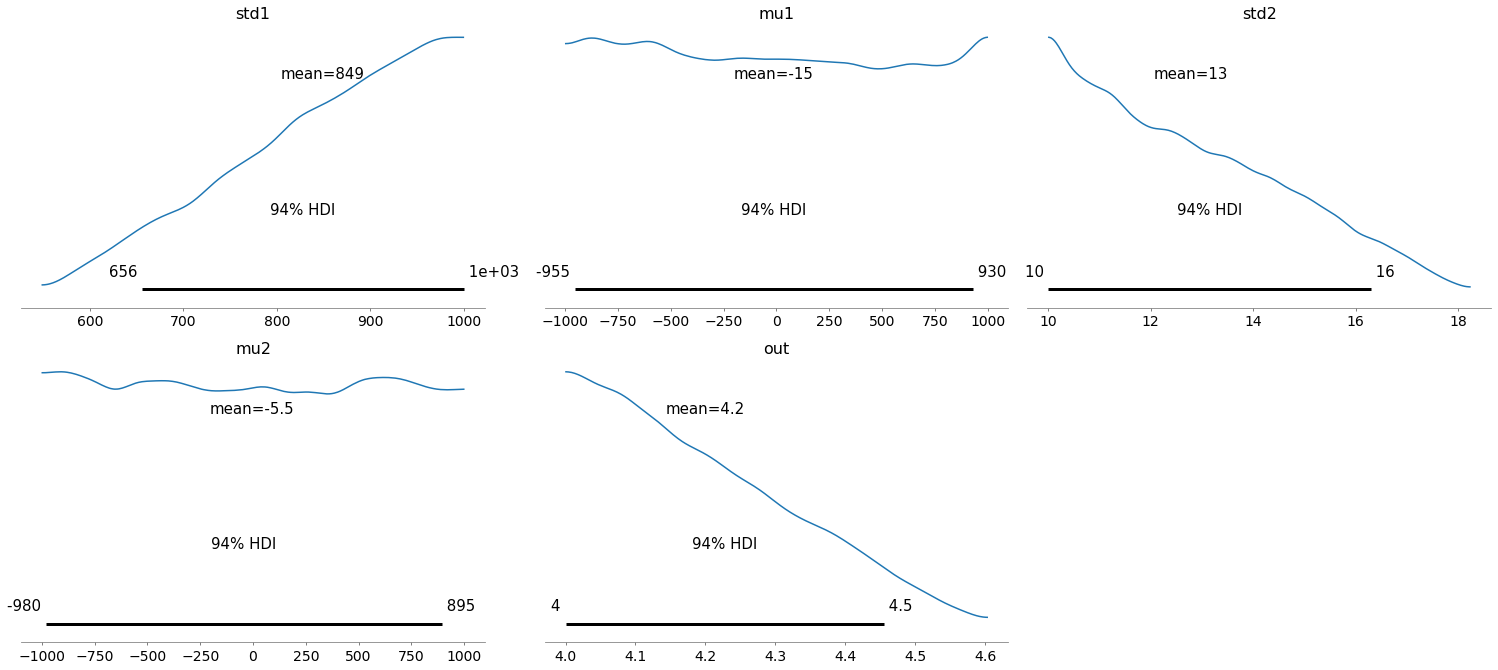

In [57]:
az.plot_posterior(trace)

In [3]:
with pm.Model() as model:
    s1 = pm.Uniform("std1", 10,1000)
    mus1 = pm.Uniform("mu1", -1000,1000)
    s2 = pm.Uniform("std2", 10,1000)
    mus2 = pm.Uniform("mu2", -1000,1000)
    
    Is = pm.Deterministic("out", (np.log(np.power(s1,2) + np.power(s2,2)) -np.log(np.power(s2,2)))/2)
    Is2 = pm.Deterministic("ou2t", (np.log(np.power(s1,2) + np.power(s2,2)) -np.log(np.power(s2,2)))/2)
    obs = pm.Normal("obs", Is> Is2, 0.1, observed = 1)
    
    trace = pm.sample(10_000, cores=2, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu2, std2, mu1, std1]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.


/home/maoj/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'std1'}>,
        <AxesSubplot:title={'center':'mu1'}>,
        <AxesSubplot:title={'center':'std2'}>],
       [<AxesSubplot:title={'center':'mu2'}>,
        <AxesSubplot:title={'center':'out'}>,
        <AxesSubplot:title={'center':'ou2t'}>]], dtype=object)

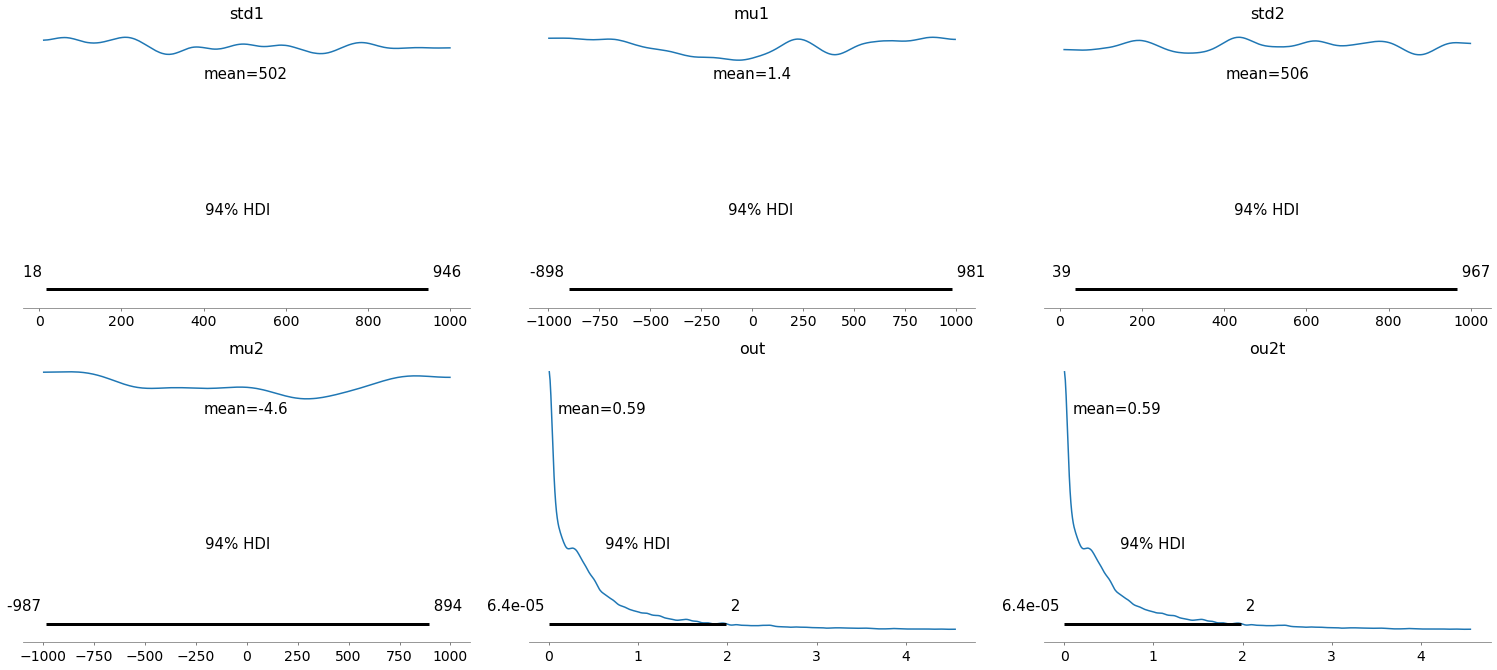

In [4]:
az.plot_posterior(trace)

In [15]:
y1, y2 = [],[]
for i in range(10):
    y1.append(np.random.randint(0,10))
    rng = np.random.RandomState(12345)
    y2.append(rng.randint(0,10))
print(np.diff(y1))

print(np.diff(y2))

[-1  5  3 -6  7 -5  3  2 -4]
[0 0 0 0 0 0 0 0 0]


<ErrorbarContainer object of 3 artists>

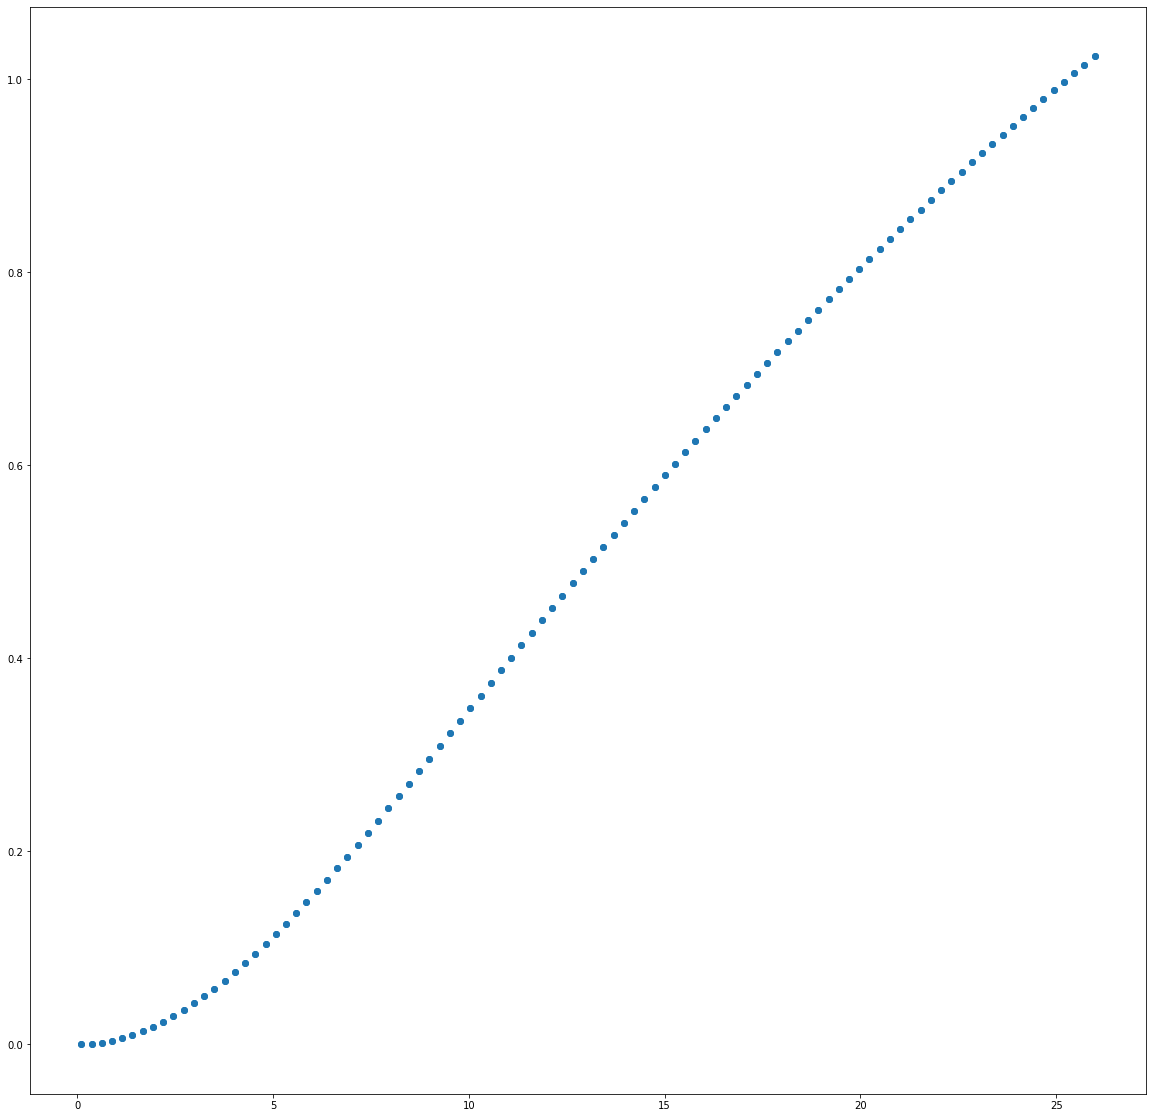

In [29]:
sigma = np.linspace(0.1,15*np.sqrt(3), 100)
def numpy_normal2(s1,s2, mu1, mu2):
    #s1,s2 = X
    x = np.random.normal(mu1, s1, size=10_000)
    y = np.random.normal(mu2, s2, size=10_000)

    out = x+y
    I = mutual_info_regression(x.reshape((-1,1)),out, discrete_features=False)[0]
    return np.array(I, dtype=np.float64)
def analytical_solution(mu1, mu2, std_alice, std_res):
    return np.array((np.log(std_alice**2+std_res**2)-np.log(std_res**2))/2)
x = []
x_real = []
y = []
err = []
for si in sigma:
    currentErr = []
    x_real.append(analytical_solution(0,0,si,10))
    for i in range(10):
        currentErr.append(abs(x_real[-1] - numpy_normal2(si,10, 0, 0)))
    err.append(max(currentErr))
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.scatter(sigma, x_real)
ax.errorbar(sigma, x_real, xerr=err, fmt="o")

In [30]:
err

[0.01316668440873947,
 0.0011497956901953543,
 0.010755625637522748,
 0.0038944215641927293,
 0.01749396145276405,
 0.018923635220189805,
 0.01382746234965726,
 0.008984425054047396,
 0.014514136503128494,
 0.012677285824795437,
 0.01598015521986973,
 0.025090380914079002,
 0.014358228260364925,
 0.012563795742810857,
 0.020796593960032972,
 0.02303461183118749,
 0.013222655981667497,
 0.013879943043516363,
 0.010773702139826646,
 0.010475800952699288,
 0.013400221869838802,
 0.020392427505625754,
 0.017478229902653464,
 0.017781679264607497,
 0.018078897976557595,
 0.0167536565615789,
 0.014081460582052507,
 0.01651472968557055,
 0.01485827405210216,
 0.014590892497698071,
 0.012479331976594565,
 0.023223552520494906,
 0.02606688881067054,
 0.014007560600944657,
 0.020142741276408138,
 0.01991593278419579,
 0.01925833264353205,
 0.014882986370974294,
 0.021019126498488028,
 0.025718941546146734,
 0.01349898184175835,
 0.013852931265648127,
 0.021718718012252225,
 0.01673532710025194,


<ErrorbarContainer object of 3 artists>

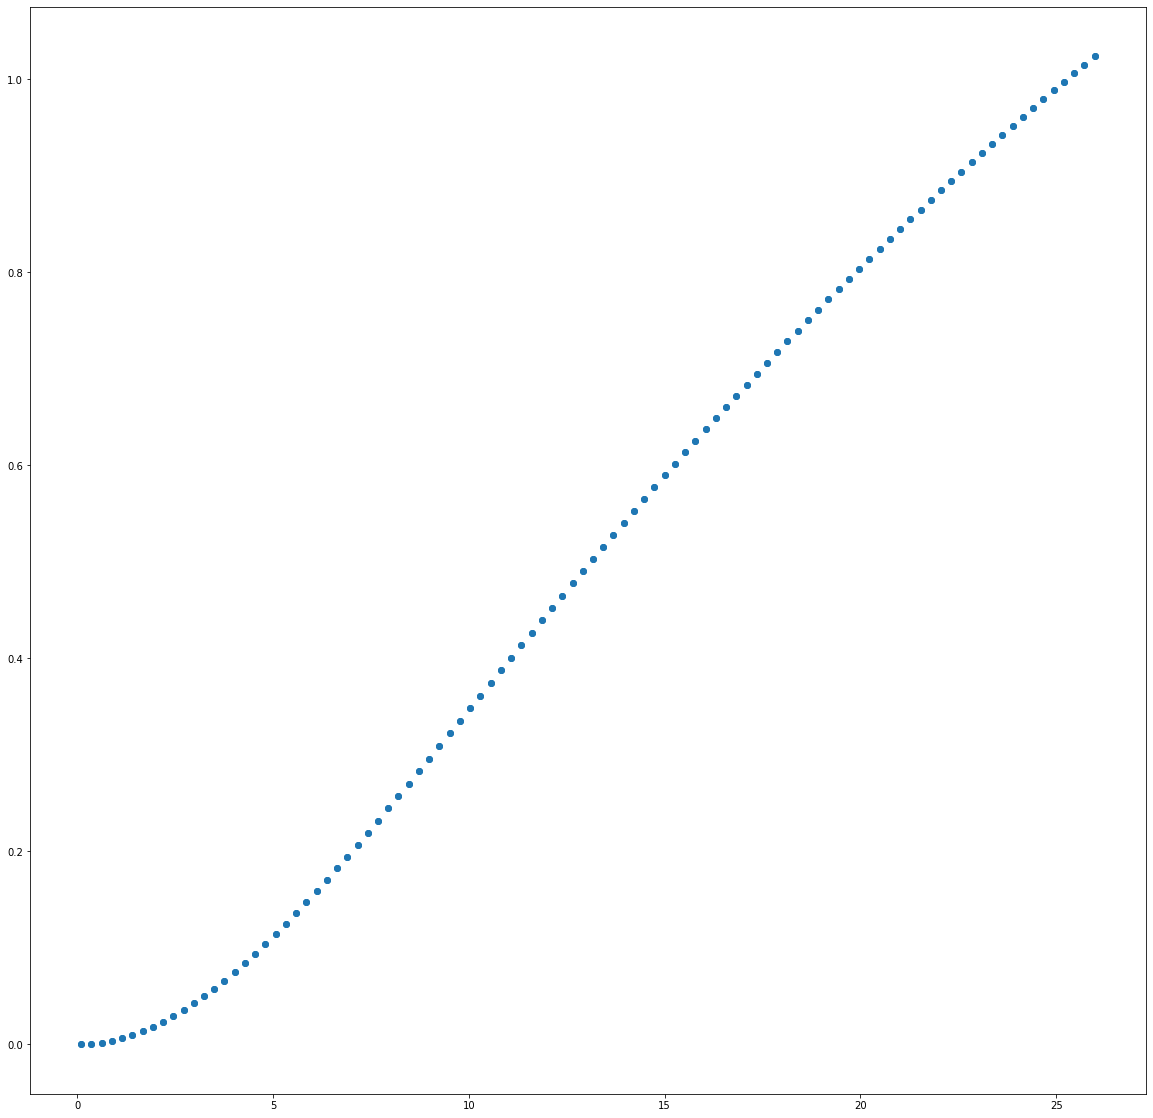

In [31]:
sigma = np.linspace(0.1,15*np.sqrt(3), 100)
def numpy_normal2(s1,s2, mu1, mu2, rng):
    #s1,s2 = X
    
    x = rng.normal(mu1, s1, size=10_000)
    y = rng.normal(mu2, s2, size=10_000)

    out = x+y
    I = mutual_info_regression(x.reshape((-1,1)),out, discrete_features=False, random_state=rng)[0]
    return np.array(I, dtype=np.float64)
def analytical_solution(mu1, mu2, std_alice, std_res):
    return np.array((np.log(std_alice**2+std_res**2)-np.log(std_res**2))/2)
x = []
x_real = []
y = []
err = []
rng = np.random.RandomState(12345)
for si in sigma:
    currentErr = []
    x_real.append(analytical_solution(0,0,si,10))
    for i in range(10):
        currentErr.append(abs(x_real[-1] - numpy_normal2(si,10, 0, 0, rng)))
    err.append(max(currentErr))
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.scatter(sigma, x_real)
ax.errorbar(sigma, x_real, xerr=err, fmt="o")

In [32]:
err

[0.009365281242377677,
 0.009259208523689999,
 0.025017285610288376,
 0.0152919129095479,
 0.006520297919912377,
 0.009803050532887436,
 0.02273078075565227,
 0.019700011401134088,
 0.012472467682658195,
 0.014316017308409368,
 0.012330596938072702,
 0.014393051959627368,
 0.011738562171945688,
 0.019818385592935694,
 0.012075023914784211,
 0.013389106370386372,
 0.01314632731645693,
 0.015253551829549572,
 0.020036450920339455,
 0.014045137758096793,
 0.008188413617919998,
 0.016325825150527606,
 0.016932758085469235,
 0.01898018085288289,
 0.022557577472670953,
 0.02017146706111994,
 0.021102266271064707,
 0.024025294237056016,
 0.016146747822413765,
 0.011434283132647494,
 0.02151846497207277,
 0.026347210052264813,
 0.013595742119036025,
 0.03110992924559053,
 0.01581984829900307,
 0.00985937576810425,
 0.01793706241494597,
 0.017289946620270058,
 0.024056590288392243,
 0.024580632774819033,
 0.030236828174190045,
 0.019728887127171912,
 0.011996134517543666,
 0.022632507893297404,